In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals/dogs/dogs_00583.jpg
/kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals/dogs/dogs_00683.jpg
/kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals/dogs/dogs_00750.jpg
/kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals/dogs/dogs_00652.jpg
/kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals/dogs/dogs_00895.jpg
/kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals/dogs/dogs_00686.jpg
/kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals/dogs/dogs_00622.jpg
/kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals/dogs/dogs_00291.jpg
/kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals/dogs/dogs_00944.jpg
/kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals/dogs/dogs_00082.jpg
/kaggle/input/animal-detection-dataset-c

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
root = r"/kaggle/input/animal-detection-dataset-cats-dogs-and-pandas/archive/animals"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [4]:
data = datasets.ImageFolder(root=root, transform=train_transform)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

class_names = data.classes
print("Classes:", class_names)
print(f"Training images: {len(train_data)}")
print(f"Testing images:  {len(test_data)}")


Classes: ['cats', 'dogs', 'panda']
Training images: 2400
Testing images:  600


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VGG19model = models.vgg19(pretrained=True)

for param in VGG19model.parameters():
    param.requires_grad = False

torch.manual_seed(42)
VGG19model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 3), 
    nn.LogSoftmax(dim=1)
)

VGG19model = VGG19model.to(device)
print(VGG19model.classifier)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 215MB/s] 


Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=3, bias=True)
  (4): LogSoftmax(dim=1)
)


In [6]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(VGG19model.classifier.parameters(), lr=0.001)

In [8]:
epochs = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    VGG19model.train()
    running_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        log_ps = VGG19model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    else:
        test_loss = 0
        accuracy = 0
        VGG19model.eval()
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                log_ps = VGG19model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/len(train_loader):.3f}.. "
              f"Test loss: {test_loss/len(test_loader):.3f}.. "
              f"Test accuracy: {accuracy/len(test_loader):.3f}")

Epoch 1/10.. Train loss: 0.311.. Test loss: 0.172.. Test accuracy: 0.990
Epoch 2/10.. Train loss: 0.144.. Test loss: 0.235.. Test accuracy: 0.982
Epoch 3/10.. Train loss: 0.171.. Test loss: 0.278.. Test accuracy: 0.985
Epoch 4/10.. Train loss: 0.346.. Test loss: 0.256.. Test accuracy: 0.980
Epoch 5/10.. Train loss: 0.300.. Test loss: 1.008.. Test accuracy: 0.957
Epoch 6/10.. Train loss: 0.318.. Test loss: 1.034.. Test accuracy: 0.960
Epoch 7/10.. Train loss: 0.198.. Test loss: 0.300.. Test accuracy: 0.980
Epoch 8/10.. Train loss: 0.197.. Test loss: 0.301.. Test accuracy: 0.987
Epoch 9/10.. Train loss: 0.224.. Test loss: 0.611.. Test accuracy: 0.977
Epoch 10/10.. Train loss: 0.231.. Test loss: 0.521.. Test accuracy: 0.982


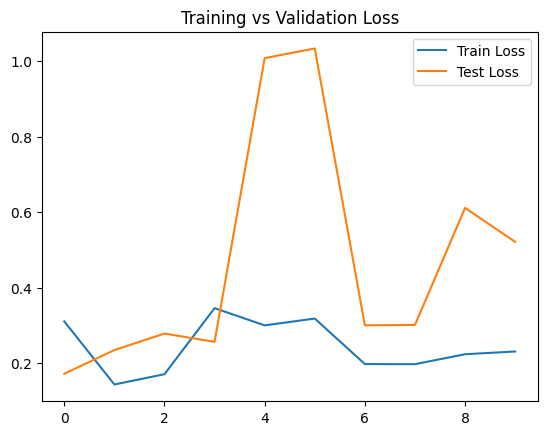

In [10]:
plt.plot([x.cpu().item() if torch.is_tensor(x) else x for x in train_losses], label='Train Loss')
plt.plot([x.cpu().item() if torch.is_tensor(x) else x for x in test_losses], label='Test Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [11]:
torch.save(VGG19model.state_dict(), "vgg19_cats_dogs_pandas.pth")
print("Model saved successfully.")

Model saved successfully.


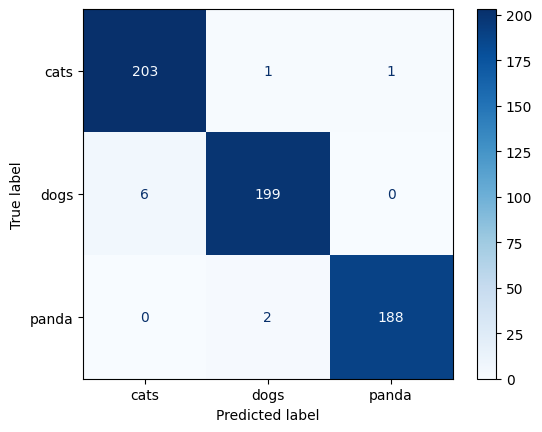

In [12]:
VGG19model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = VGG19model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()